In [2]:
import numpy as np
from pathlib import Path
from utils import project_root
import os
import pymap3d as pm
import matplotlib.pyplot as plt
import matplotlib
from scipy.spatial.transform import Rotation

%matplotlib inline
matplotlib.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,12)

# Helpers

In [39]:
# function to return the index of the closest IMU reading to the given timestamp
def get_IMU_reading(time, imu_times):
    min_dt = 10000
    for idx, stamp in enumerate(imu_times):
        #print(stamp, time)
        dt = abs(stamp - time)
        if dt<min_dt:
            min_dt = dt
            min_idx = idx
            
        # if we found a very close reading, stop
        if min_dt < 0.01:
            break

    return min_dt, min_idx

In [3]:
def traj_RMSE(gt, est):
    e = gt-est
    se = e**2
    mse = np.mean(se)
    rmse = np.sqrt(mse)
    
    return rmse

In [4]:
rot_order = 'xyz'

In [5]:
def tt_from_t(t_state):
    for t in t_state:
        if t < 1800:
            t0_imu = t
            break

    tt_state = []        
    for t in t_state:
        if t < 1800:
            tt_state.append(t-t0_imu)
        else:
            tt_state.append(t-t_state[0])
    tt_state = np.array(tt_state)
    
    return tt_state

In [6]:
# convert quaternions to euler
def quat2euler(q_in, axis=rot_order):
    q_in_ = np.array([q_in[1], q_in[2], q_in[3], q_in[0]]).reshape((4,1)) # [w, x, y, z] -> [x, y, z, w]
    
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_quat(q_in_.flatten()) # [x, y, z, w]

    # Convert to euler
    rot_euler = rot.as_euler(axis) # [x,y,z]
    
    return rot_euler.reshape((3,1))

# Load data

In [7]:
os.chdir(Path(project_root() / 'data/topics/validation_no_heading'))

## GPS position - ground truth

In [8]:
# load ROS data from txt file
lines = []
with open('gps_position.txt') as f:
    lines = f.readlines()

    x_gps = []
    y_gps = []
    sec_gps = []
    nsec_gps = []
    count = 0
    for line in lines:
        count += 1
        if line[4:8] == "sec:":
            t = int(line[9:-1])
            sec_gps.append(t)
        elif line[4:12] == "nanosec:":
            nsec_gps.append(int(line[13:-1]))
        elif line[0:2] == "x:":
            x_gps.append(float(line[2:-1]))
        elif line[0:2] == "y:":
            y_gps.append(float(line[2:-1]))

temp = [i*1e-9 for i in nsec_gps]
t_gps_pos = [sum(x) for x in zip(sec_gps, temp)]
tt_gps_pos = np.array([x-t_gps_pos[0] for x in t_gps_pos])

x_gps = np.array(x_gps)
y_gps = np.array(y_gps)
gps_pos = np.stack((x_gps, y_gps), 1)

In [9]:
print(len(tt_gps_pos), gps_pos.shape)

913 (913, 2)


## GPS (fault) position

In [10]:
# load ROS data from txt file
lines = []
with open('gps_positionf.txt') as f:
    lines = f.readlines()

    x_gpsf = []
    y_gpsf = []
    sec_gps = []
    nsec_gps = []
    count = 0
    for line in lines:
        count += 1
        if line[4:8] == "sec:":
            t = int(line[9:-1])
            sec_gps.append(t)
        elif line[4:12] == "nanosec:":
            nsec_gps.append(int(line[13:-1]))
        elif line[0:2] == "x:":
            x_gpsf.append(float(line[2:-1]))
        elif line[0:2] == "y:":
            y_gpsf.append(float(line[2:-1]))

temp = [i*1e-9 for i in nsec_gps]
t_gps_posf = [sum(x) for x in zip(sec_gps, temp)]
tt_gps_posf = np.array([x-t_gps_pos[0] for x in t_gps_posf])

x_gpsf = np.array(x_gpsf)
y_gpsf = np.array(y_gpsf)
gps_posf = np.stack((x_gpsf, y_gpsf), 1)

In [11]:
print(len(tt_gps_posf), gps_posf.shape)

908 (908, 2)


## GPS velocity - from position differentiation

In [12]:
# extract linear velocities from differentiating gps positions
dx_gps = []
dy_gps = []
for i in range(len(t_gps_pos)):
    # in the first iteration, get x,y from gps and theta from imu
    if i==0:
        vx, vy = 0, 0
    # in the rest, get it from kinematics
    else:
        # get dt in seconds
        dt = t_gps_pos[i] - t_gps_pos[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}")

        # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
        vx = (x_gps.flatten()[i] - x_gps.flatten()[i-1])/dt
        vy = (y_gps.flatten()[i] - y_gps.flatten()[i-1])/dt

    dx_gps.append(vx)
    dy_gps.append(vy)

dx_gps = np.array(dx_gps)
dy_gps = np.array(dy_gps)
gps_dp = np.stack((dx_gps, dy_gps), 1)

In [13]:
print(len(t_gps_pos), gps_dp.shape)

913 (913, 2)


## Radar Odom data

In [14]:
# load ROS data from txt file
lines = []
with open('ro.txt') as f:
    lines = f.readlines()

    n = []
    v = []
    w = []
    lsq_ssr = []
    ransac_ssr = []
    sec = []
    nsec = []
    for line in lines:        
        # find what we are saving
        if line[4:7] == "sec":
            t = int(line[9:-1])
            if sec and t < sec[-1]:
                print("WTF", t)
            sec.append(t)
        elif line[4:11] == "nanosec":
            nsec.append(int(line[13:-1]))
        elif line[0:10] == "num_points":
            n.append(int(line[12:-1]))
        elif line[0:16] == "heading_velocity":
            v.append(float(line[18:-1]))
        elif line[0:8] == "yaw_rate":
            w.append(float(line[10:-1]))
        elif line[0:10] == "ransac_ssr":
            ransac_ssr.append(float(line[12:-1]))
        elif line[0:7] == "lsq_ssr":
            lsq_ssr.append(float(line[9:-1]))
                
temp = [i*1e-9 for i in nsec]
t_ro = [sum(x) for x in zip(sec, temp)]
tt_ro = np.array([x-t_ro[0] for x in t_ro])

num_pts_ro = np.array(n, dtype=object)
v_ro = np.array(v, dtype=object)
w_ro = np.array(w, dtype=object)
# r_ro = np.array(R, dtype=object)
ransac_ssr_ro = np.array(ransac_ssr, dtype=object)
lsq_ssr_ro = np.array(lsq_ssr, dtype=object)

In [15]:
print(len(tt_ro), len(v_ro), len(w_ro), len(ransac_ssr_ro), len(lsq_ssr_ro))

1653 1653 1653 1653 1653


## Radar-IMU state

In [16]:
# load ROS data from txt file
lines = []
flag = None
with open('state_ri.txt') as f:
    lines = f.readlines()

    p = []
    pi = -1
    v = []
    vi = -1
    q = []
    qi = -1
    sec_state = []
    nsec_state = []
    for line in lines:
        # break at ".nan" and pop the empty list(s) that were just appended
#         if line[5:-1] == ".nan":
#             sec_state.pop()
#             nsec_state.pop()
#             if flag == 'p':
#                 p.pop()
#             elif flag == 'v':
#                 p.pop()
#                 v.pop()
#             elif flag == 'q':
#                 p.pop()
#                 v.pop()
#                 q.pop()
#             break
        
        # find what we are saving
        if line[4:7] == "sec":
            sec_state.append(int(line[9:-1]))
        elif line[4:11] == "nanosec":
            nsec_state.append(int(line[13:-1]))
#         elif line[12:15] == "GPS":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2] 
#         elif line[12:15] == "Rad":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2]
        elif line[0:2] == "p:":
            p.append([])
            flag = 'p'
            pi += 1
        elif line[0:2] == "v:":
            v.append([])
            vi += 1
            flag = 'v'
        elif line[0:2] == "q:":
            q.append([])
            qi += 1
            flag = 'q'
        
        # save to the corresponding list
        if flag == 'p':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                p[pi].append(float(line[5:-1]))
        elif flag == 'v':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                v[pi].append(float(line[5:-1]))
        elif flag == 'q':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:" or line[2:4] == "w:":
                q[qi].append(float(line[5:-1]))
                if line[2:4] == "w:":
                    flag = None

temp = [i*1e-9 for i in nsec_state]
t_state2 = [sum(x) for x in zip(sec_state, temp)]
tt_state2 = tt_from_t(t_state2)

p2 = np.array(p, dtype=object)
v2 = np.array(v, dtype=object)
q2 = np.array(q, dtype=object)

In [17]:
print(len(tt_state2), len(p2), len(v2), len(q2))

10770 10770 10770 10770


## GPS-IMU state

In [18]:
# load ROS data from txt file
lines = []
flag = None
with open('state_gi.txt') as f:
    lines = f.readlines()

    p = []
    pi = -1
    v = []
    vi = -1
    q = []
    qi = -1
    sec_state = []
    nsec_state = []
    for line in lines:
        # break at ".nan" and pop the empty list(s) that were just appended
#         if line[5:-1] == ".nan":
#             sec_state.pop()
#             nsec_state.pop()
#             if flag == 'p':
#                 p.pop()
#             elif flag == 'v':
#                 p.pop()
#                 v.pop()
#             elif flag == 'q':
#                 p.pop()
#                 v.pop()
#                 q.pop()
#             break
        
        # find what we are saving
        if line[4:7] == "sec":
            sec_state.append(int(line[9:-1]))
        elif line[4:11] == "nanosec":
            nsec_state.append(int(line[13:-1]))
#         elif line[12:15] == "GPS":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2] 
#         elif line[12:15] == "Rad":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2]
        elif line[0:2] == "p:":
            p.append([])
            flag = 'p'
            pi += 1
        elif line[0:2] == "v:":
            v.append([])
            vi += 1
            flag = 'v'
        elif line[0:2] == "q:":
            q.append([])
            qi += 1
            flag = 'q'
        
        # save to the corresponding list
        if flag == 'p':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                p[pi].append(float(line[5:-1]))
        elif flag == 'v':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                v[pi].append(float(line[5:-1]))
        elif flag == 'q':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:" or line[2:4] == "w:":
                q[qi].append(float(line[5:-1]))
                if line[2:4] == "w:":
                    flag = None

temp = [i*1e-9 for i in nsec_state]
t_state1 = [sum(x) for x in zip(sec_state, temp)]
tt_state1 = tt_from_t(t_state1)

p1 = np.array(p, dtype=object)
v1 = np.array(v, dtype=object)
q1 = np.array(q, dtype=object)

In [19]:
print(len(tt_state1), len(p1), len(v1), len(q1))

9984 9984 9984 9984


## GPS-IMU-Radar state

In [20]:
# load ROS data from txt file
lines = []
flag = None
with open('state_gri.txt') as f:
    lines = f.readlines()

    p = []
    pi = -1
    v = []
    vi = -1
    q = []
    qi = -1
    sec_state = []
    nsec_state = []
    for line in lines:
        # break at ".nan" and pop the empty list(s) that were just appended
#         if line[5:-1] == ".nan":
#             sec_state.pop()
#             nsec_state.pop()
#             if flag == 'p':
#                 p.pop()
#             elif flag == 'v':
#                 p.pop()
#                 v.pop()
#             elif flag == 'q':
#                 p.pop()
#                 v.pop()
#                 q.pop()
#             break
        
        # find what we are saving
        if line[4:7] == "sec":
            sec_state.append(int(line[9:-1]))
        elif line[4:11] == "nanosec":
            nsec_state.append(int(line[13:-1]))
#         elif line[12:15] == "GPS":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2] 
#         elif line[12:15] == "Rad":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2]
        elif line[0:2] == "p:":
            p.append([])
            flag = 'p'
            pi += 1
        elif line[0:2] == "v:":
            v.append([])
            vi += 1
            flag = 'v'
        elif line[0:2] == "q:":
            q.append([])
            qi += 1
            flag = 'q'
        
        # save to the corresponding list
        if flag == 'p':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                p[pi].append(float(line[5:-1]))
        elif flag == 'v':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                v[pi].append(float(line[5:-1]))
        elif flag == 'q':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:" or line[2:4] == "w:":
                q[qi].append(float(line[5:-1]))
                if line[2:4] == "w:":
                    flag = None

temp = [i*1e-9 for i in nsec_state]
t_state0 = [sum(x) for x in zip(sec_state, temp)]
tt_state0 = tt_from_t(t_state0)

p0 = np.array(p, dtype=object)
v0 = np.array(v, dtype=object)
q0 = np.array(q, dtype=object)

In [21]:
print(len(tt_state0), len(p0), len(v0), len(q0))

11566 11566 11566 11566


## GPS (loss) - IMU - radar state

In [22]:
# load ROS data from txt file
lines = []
flag = None
with open('state_l.txt') as f:
    lines = f.readlines()

    p = []
    pi = -1
    v = []
    vi = -1
    q = []
    qi = -1
    sec_state = []
    nsec_state = []
    for line in lines:
        # break at ".nan" and pop the empty list(s) that were just appended
#         if line[5:-1] == ".nan":
#             sec_state.pop()
#             nsec_state.pop()
#             if flag == 'p':
#                 p.pop()
#             elif flag == 'v':
#                 p.pop()
#                 v.pop()
#             elif flag == 'q':
#                 p.pop()
#                 v.pop()
#                 q.pop()
#             break
        
        # find what we are saving
        if line[4:7] == "sec":
            sec_state.append(int(line[9:-1]))
        elif line[4:11] == "nanosec":
            nsec_state.append(int(line[13:-1]))
#         elif line[12:15] == "GPS":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2] 
#         elif line[12:15] == "Rad":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2]
        elif line[0:2] == "p:":
            p.append([])
            flag = 'p'
            pi += 1
        elif line[0:2] == "v:":
            v.append([])
            vi += 1
            flag = 'v'
        elif line[0:2] == "q:":
            q.append([])
            qi += 1
            flag = 'q'
        
        # save to the corresponding list
        if flag == 'p':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                p[pi].append(float(line[5:-1]))
        elif flag == 'v':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                v[pi].append(float(line[5:-1]))
        elif flag == 'q':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:" or line[2:4] == "w:":
                q[qi].append(float(line[5:-1]))
                if line[2:4] == "w:":
                    flag = None

temp = [i*1e-9 for i in nsec_state]
t_statel = [sum(x) for x in zip(sec_state, temp)]
tt_statel = tt_from_t(t_statel)

pl = np.array(p, dtype=object)
vl = np.array(v, dtype=object)
ql = np.array(q, dtype=object)

In [23]:
print(len(tt_statel), len(pl), len(vl), len(ql))

11782 11782 11782 11782


## GPS (fault) - IMU - radar state

In [24]:
# load ROS data from txt file
lines = []
flag = None
with open('state_f.txt') as f:
    lines = f.readlines()

    p = []
    pi = -1
    v = []
    vi = -1
    q = []
    qi = -1
    sec_state = []
    nsec_state = []
    for line in lines:
        # break at ".nan" and pop the empty list(s) that were just appended
#         if line[5:-1] == ".nan":
#             sec_state.pop()
#             nsec_state.pop()
#             if flag == 'p':
#                 p.pop()
#             elif flag == 'v':
#                 p.pop()
#                 v.pop()
#             elif flag == 'q':
#                 p.pop()
#                 v.pop()
#                 q.pop()
#             break
        
        # find what we are saving
        if line[4:7] == "sec":
            sec_state.append(int(line[9:-1]))
        elif line[4:11] == "nanosec":
            nsec_state.append(int(line[13:-1]))
#         elif line[12:15] == "GPS":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2] 
#         elif line[12:15] == "Rad":
#             sec_state[-1] = sec_state[-2]
#             nsec_state[-1] = nsec_state[-2]
        elif line[0:2] == "p:":
            p.append([])
            flag = 'p'
            pi += 1
        elif line[0:2] == "v:":
            v.append([])
            vi += 1
            flag = 'v'
        elif line[0:2] == "q:":
            q.append([])
            qi += 1
            flag = 'q'
        
        # save to the corresponding list
        if flag == 'p':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                p[pi].append(float(line[5:-1]))
        elif flag == 'v':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:":
                v[pi].append(float(line[5:-1]))
        elif flag == 'q':
            if line[2:4] == "x:" or line[2:4] == "y:" or line[2:4] == "z:" or line[2:4] == "w:":
                q[qi].append(float(line[5:-1]))
                if line[2:4] == "w:":
                    flag = None

temp = [i*1e-9 for i in nsec_state]
t_statef = [sum(x) for x in zip(sec_state, temp)]
tt_statef = tt_from_t(t_statef)

pf = np.array(p, dtype=object)
vf = np.array(v, dtype=object)
qf = np.array(q, dtype=object)

In [25]:
print(len(tt_statel), len(pl), len(vl), len(ql))

11782 11782 11782 11782


# Visualize

## Radar Odom results

### Extract residuals

In [26]:
gps_heading_vel = np.sqrt(dx_gps**2 + dy_gps**2)

In [27]:
# function to return the index of the closest reading to the given timestamp
def get_close_reading(time, times):
    min_dt = 10000
    for idx, stamp in enumerate(times):
        dt = abs(stamp - time)
        if dt<min_dt:
            min_dt = dt
            min_idx = idx
            
        # if we found a very close reading, stop
        if min_dt < 0.01:
            break

    return min_dt, min_idx

In [28]:
vel_resids = []
for i in range(len(v_ro)):
    # get closest imu reading
    e, idx = get_close_reading(tt_ro[i], tt_gps_pos)
    
    vel_resids.append(gps_heading_vel[idx]- v_ro[i])

print("Mean difference between GPS and Radar heading velocity: ", np.mean(vel_resids), "m/sec")

Mean difference between GPS and Radar heading velocity:  -0.006206804193787252 m/sec


### Plots

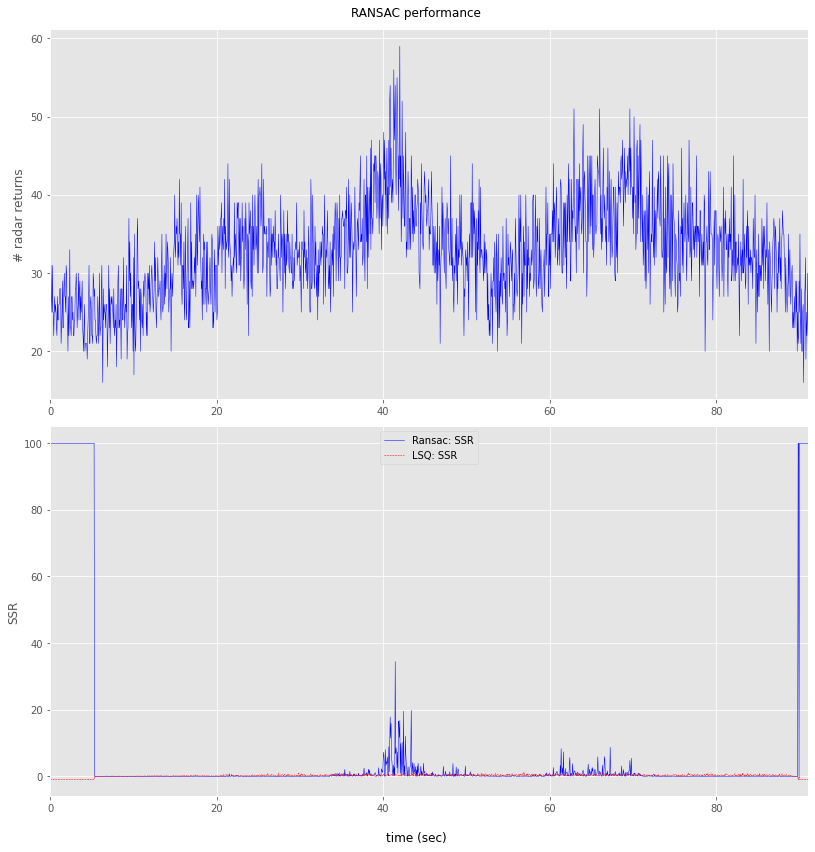

In [29]:
# visualize velocity
fig, axs = plt.subplots(2)

axs[0].plot(tt_ro, num_pts_ro, 'b-', linewidth=.5)
axs[1].plot(tt_ro, ransac_ssr_ro, 'b-', linewidth=.5, label="Ransac: SSR")
axs[1].plot(tt_ro, lsq_ssr_ro, 'r--', linewidth=.5, label="LSQ: SSR")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
# axs[0].legend()
axs[1].legend()

fig.supxlabel("time (sec)")
axs[0].set_ylabel("# radar returns")
axs[1].set_ylabel("SSR")
for i in range(2):
    axs[i].set_xlim([tt_ro[0], tt_ro[-1]])
plt.suptitle("RANSAC performance")
plt.show()

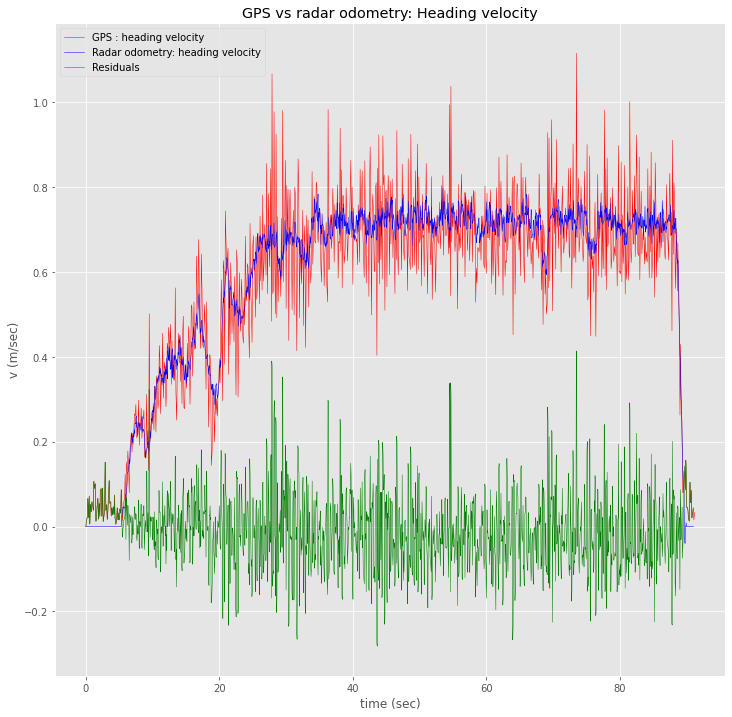

In [30]:
fig, ax = plt.subplots()

ax.plot(tt_gps_pos, gps_heading_vel, 'r-', linewidth=0.5, label="GPS : heading velocity")
ax.plot(tt_ro, v_ro, 'b-', linewidth=.5, label="Radar odometry: heading velocity")
ax.plot(tt_ro, vel_resids, 'g-', linewidth=.5, label="Residuals")

ax.set_xlabel("time (sec)")
ax.set_ylabel("v (m/sec)")
ax.set_title("GPS vs radar odometry: Heading velocity")
ax.legend()
plt.show()

## Orientation

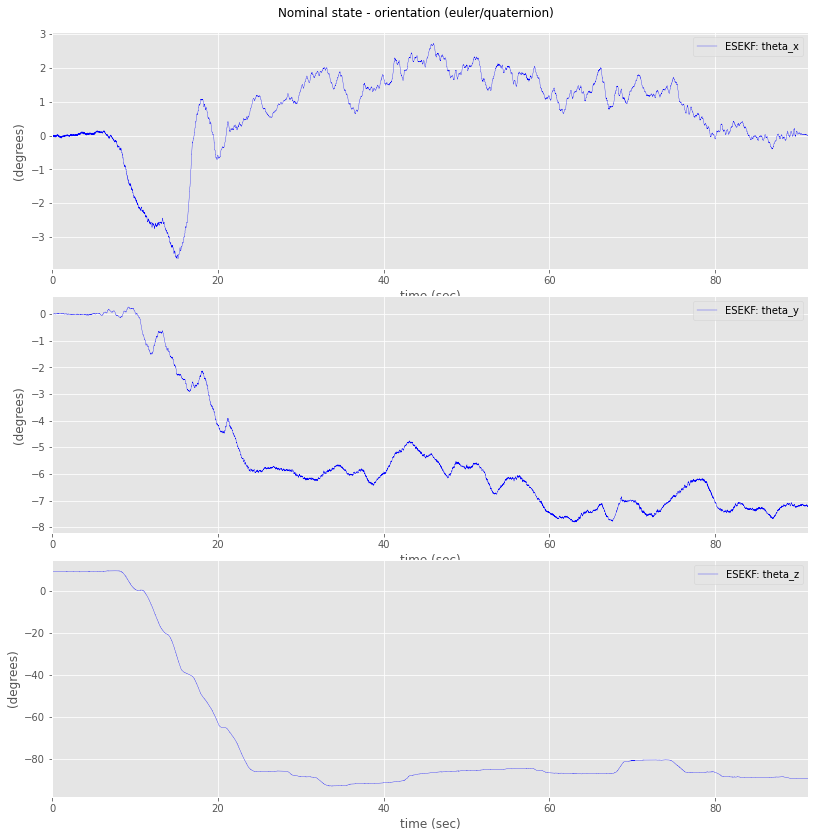

In [31]:
# visualize orientation  
## transform state orientation to euler
state_e = np.empty((0,3), float)
for x in q2:
    y = [x[3], x[0], x[1], x[2]]
    e = quat2euler(y)
    state_e = np.append(state_e, [e.flatten()], axis=0)
    
fig, axs = plt.subplots(3)

axs[0].plot(tt_state2, np.rad2deg(state_e[:,0]), 'b-', linewidth=0.3, label="ESEKF: theta_x")
axs[1].plot(tt_state2, np.rad2deg(state_e[:,1]), 'b-', linewidth=0.3, label="ESEKF: theta_y")
axs[2].plot(tt_state2, np.rad2deg(state_e[:,2]), 'b-', linewidth=0.3, label="ESEKF: theta_z")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[0].set_xlabel("time (sec)")
axs[0].set_ylabel("(degrees)")
axs[1].legend()
axs[1].set_xlabel("time (sec)")
axs[1].set_ylabel("(degrees)")
axs[2].legend()
axs[2].set_xlabel("time (sec)")
axs[2].set_ylabel("(degrees)")

for i in range(3):
    axs[i].set_xlim([tt_state2[0], tt_state2[-1]])

plt.xlabel("time (sec)")
plt.suptitle("Nominal state - orientation (euler/quaternion)")
plt.show()

## Position

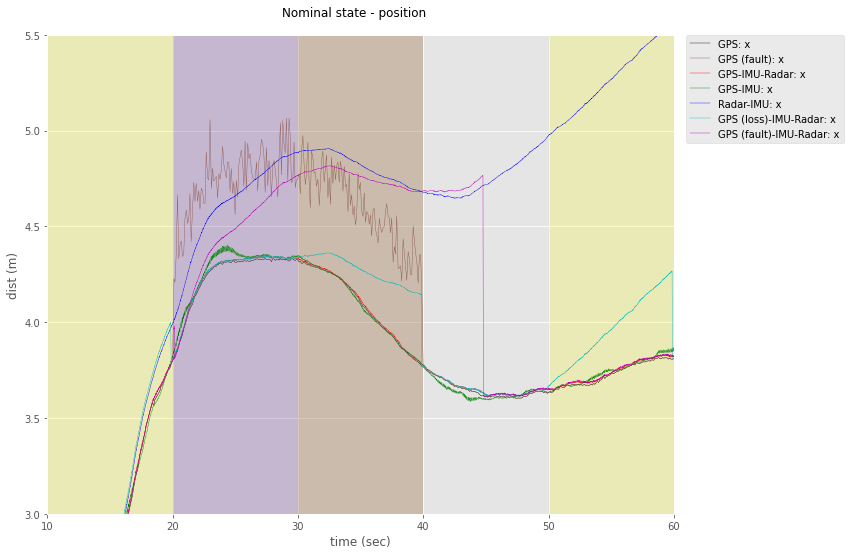

In [32]:
%matplotlib inline

# visualize position
fig, ax = plt.subplots(figsize=(10,8))

# ros2 data

ax.plot(tt_gps_pos, gps_pos[:, 0], 'k-', linewidth=.4, label="GPS: x")

ax.plot(tt_gps_posf, gps_posf[:, 0], color="tab:brown", linewidth=.4, label="GPS (fault): x")

ax.plot(tt_state0, p0[:,0], 'r-', linewidth=.4, label="GPS-IMU-Radar: x")

ax.plot(tt_state1, p1[:,0], 'g-', linewidth=.4, label="GPS-IMU: x")

ax.plot(tt_state2, p2[:,0], 'b-', linewidth=.4, label="Radar-IMU: x")

ax.plot(tt_statel, pl[:,0], 'c-', linewidth=.4, label="GPS (loss)-IMU-Radar: x")

ax.plot(tt_statef, pf[:,0], 'm-', linewidth=.4, label="GPS (fault)-IMU-Radar: x")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)

ax.set_xlim([tt_gps_pos[0], tt_gps_pos[-1]])
ax.set_xticks(np.arange(min(tt_state2), max(tt_state2), 10))

ax.set_xlim(10, 60)
ax.set_ylim(3, 5.5)

t0 = tt_state2[0]
for i in range(1,14,2):
    ax.axvspan(t0+i*10, t0+(i+1)*10, -2, 2, facecolor='yellow', alpha=0.2)
ax.axvspan(20, 40, -2, 2, facecolor='indigo', alpha=0.2)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
plt.xlabel("time (sec)")
plt.ylabel("dist (m)")
plt.suptitle("Nominal state - position")
plt.show()

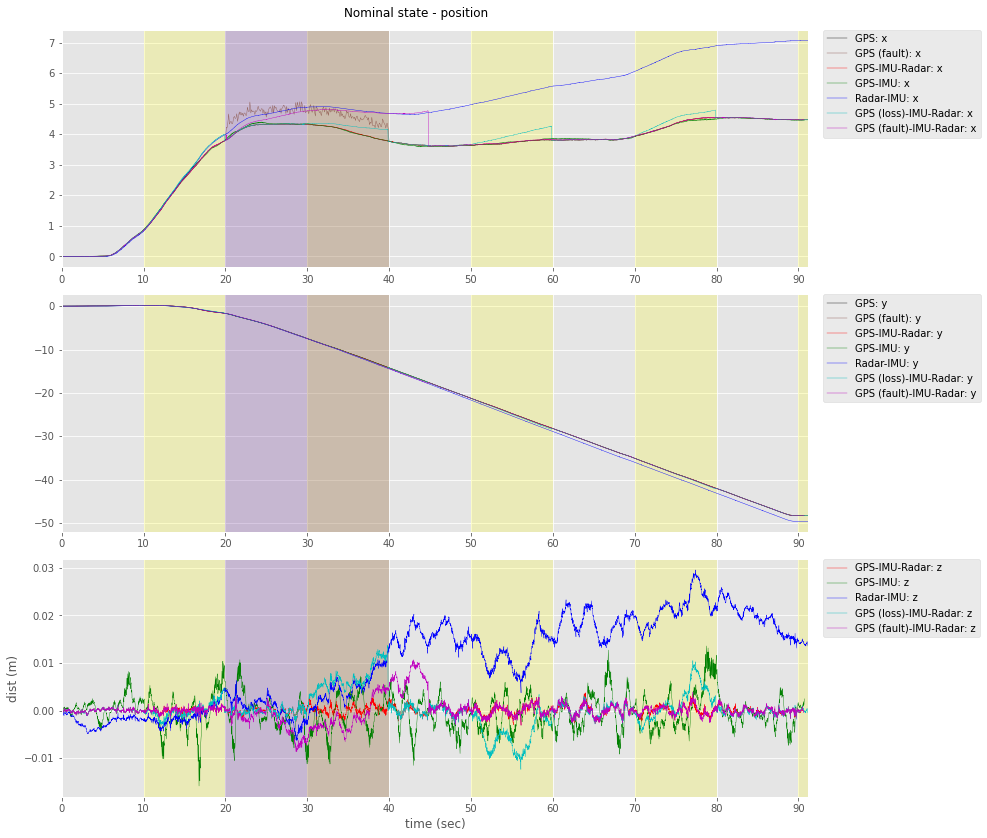

In [33]:
%matplotlib inline

# visualize position
fig, axs = plt.subplots(3, figsize=(12,12))

# ros2 data

axs[0].plot(tt_gps_pos, gps_pos[:, 0], 'k-', linewidth=.4, label="GPS: x")
axs[1].plot(tt_gps_pos, gps_pos[:, 1], 'k-', linewidth=.4, label="GPS: y")

axs[0].plot(tt_gps_posf, gps_posf[:, 0], color="tab:brown", linewidth=.4, label="GPS (fault): x")
axs[1].plot(tt_gps_posf, gps_posf[:, 1], color="tab:brown", linewidth=.4, label="GPS (fault): y")

axs[0].plot(tt_state0, p0[:,0], 'r-', linewidth=.4, label="GPS-IMU-Radar: x")
axs[1].plot(tt_state0, p0[:,1], 'r-', linewidth=.4, label="GPS-IMU-Radar: y")
axs[2].plot(tt_state0, p0[:,2], 'r-', linewidth=.4, label="GPS-IMU-Radar: z")

axs[0].plot(tt_state1, p1[:,0], 'g-', linewidth=.4, label="GPS-IMU: x")
axs[1].plot(tt_state1, p1[:,1], 'g-', linewidth=.4, label="GPS-IMU: y")
axs[2].plot(tt_state1, p1[:,2], 'g-', linewidth=.4, label="GPS-IMU: z")

axs[0].plot(tt_state2, p2[:,0], 'b-', linewidth=.4, label="Radar-IMU: x")
axs[1].plot(tt_state2, p2[:,1], 'b-', linewidth=.4, label="Radar-IMU: y")
axs[2].plot(tt_state2, p2[:,2], 'b-', linewidth=.4, label="Radar-IMU: z")

axs[0].plot(tt_statel, pl[:,0], 'c-', linewidth=.4, label="GPS (loss)-IMU-Radar: x")
axs[1].plot(tt_statel, pl[:,1], 'c-', linewidth=.4, label="GPS (loss)-IMU-Radar: y")
axs[2].plot(tt_statel, pl[:,2], 'c-', linewidth=.4, label="GPS (loss)-IMU-Radar: z")

axs[0].plot(tt_statef, pf[:,0], 'm-', linewidth=.4, label="GPS (fault)-IMU-Radar: x")
axs[1].plot(tt_statef, pf[:,1], 'm-', linewidth=.4, label="GPS (fault)-IMU-Radar: y")
axs[2].plot(tt_statef, pf[:,2], 'm-', linewidth=.4, label="GPS (fault)-IMU-Radar: z")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)

for i in range(3):
    axs[i].set_xlim([tt_gps_pos[0], tt_gps_pos[-1]])
    axs[i].set_xticks(np.arange(min(tt_state2), max(tt_state2), 10))

t0 = tt_state2[0]
for j in range(3):
    for i in range(1,14,2):
        axs[j].axvspan(t0+i*10, t0+(i+1)*10, -2, 2, facecolor='yellow', alpha=0.2)
for j in range(3):
    axs[j].axvspan(20, 40, -2, 2, facecolor='indigo', alpha=0.2)
        
for i in range(3):
    axs[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
plt.xlabel("time (sec)")
plt.ylabel("dist (m)")
plt.suptitle("Nominal state - position")
plt.show()

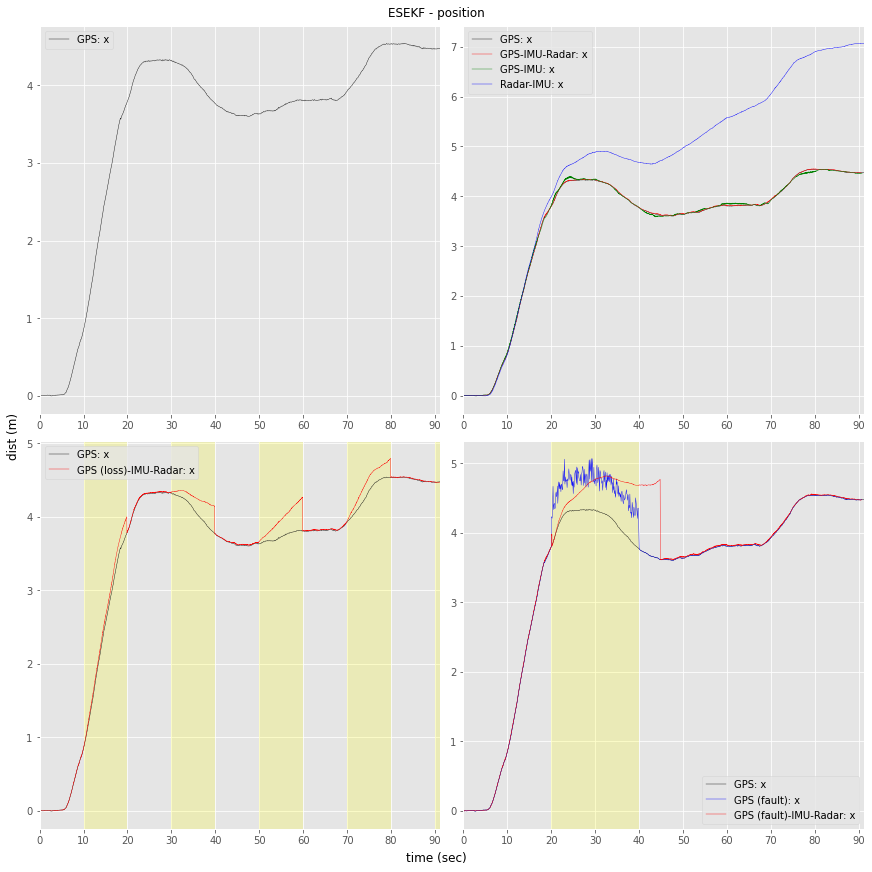

In [34]:
%matplotlib inline

# visualize position
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 12),
                        constrained_layout=True)
# ros2 data

for i in range(2):
    for j in range(2):
        axs[i,j].plot(tt_gps_pos, gps_pos[:, 0], 'k-', linewidth=.4, label="GPS: x")

axs[0,1].plot(tt_state0, p0[:,0], 'r-', linewidth=.4, label="GPS-IMU-Radar: x")
axs[0,1].plot(tt_state1, p1[:,0], 'g-', linewidth=.4, label="GPS-IMU: x")
axs[0,1].plot(tt_state2, p2[:,0], 'b-', linewidth=.4, label="Radar-IMU: x")

axs[1,0].plot(tt_statel, pl[:,0], 'r-', linewidth=.4, label="GPS (loss)-IMU-Radar: x")

axs[1,1].plot(tt_gps_posf, gps_posf[:, 0], color="b", linewidth=.4, label="GPS (fault): x")
axs[1,1].plot(tt_statef, pf[:,0], 'r-', linewidth=.4, label="GPS (fault)-IMU-Radar: x")

t0 = tt_state2[0]
for i in range(1,14,2):
    axs[1,0].axvspan(t0+i*10, t0+(i+1)*10, -2, 2, facecolor='yellow', alpha=0.2)

axs[1,1].axvspan(20, 40, -2, 2, facecolor='yellow', alpha=0.2)
        
for i in range(2):
    for j in range(2):
        axs[i,j].set_xlim([tt_gps_pos[0], tt_gps_pos[-1]])
        axs[i,j].set_xticks(np.arange(min(tt_state2), max(tt_state2), 10))
        axs[i,j].legend()

fig.supxlabel("time (sec)")
fig.supylabel("dist (m)")
fig.suptitle("ESEKF - position")
plt.show()

## Velocity

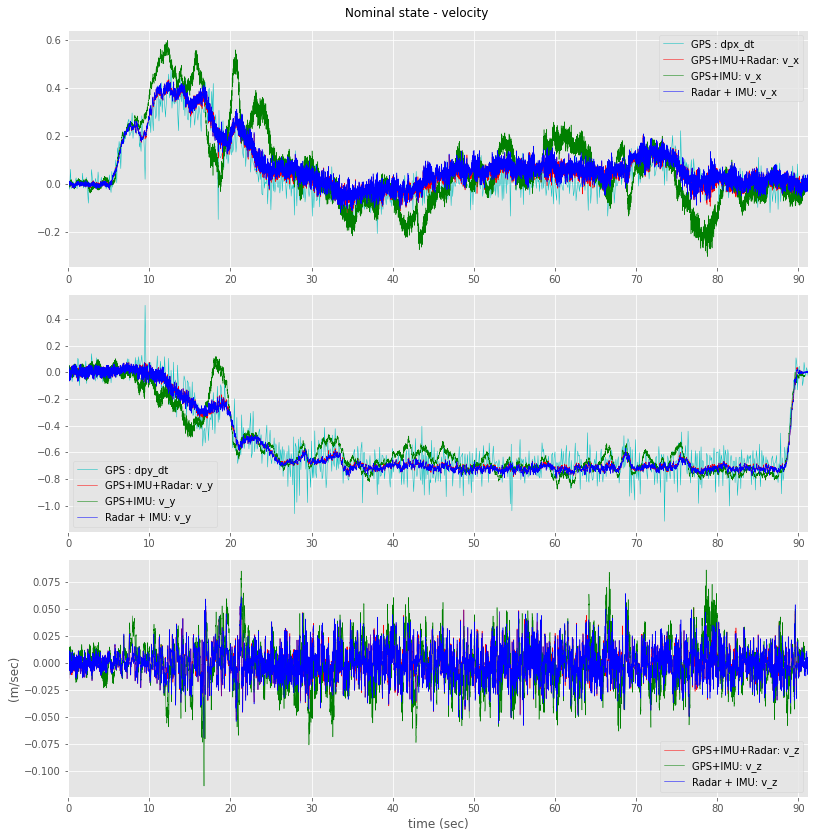

In [35]:
# visualize velocity
fig, axs = plt.subplots(3, figsize=(12, 12))

axs[0].plot(tt_gps_pos, gps_dp[:,0], 'c-', linewidth=0.5, label="GPS : dpx_dt")
axs[1].plot(tt_gps_pos, gps_dp[:,1], 'c-', linewidth=0.5, label="GPS : dpy_dt")

axs[0].plot(tt_state0, v0[:,0], 'r-', linewidth=.5, label="GPS+IMU+Radar: v_x")
axs[1].plot(tt_state0, v0[:,1], 'r-', linewidth=.5, label="GPS+IMU+Radar: v_y")
axs[2].plot(tt_state0, v0[:,2], 'r-', linewidth=.5, label="GPS+IMU+Radar: v_z")

axs[0].plot(tt_state1, v1[:,0], 'g-', linewidth=.5, label="GPS+IMU: v_x")
axs[1].plot(tt_state1, v1[:,1], 'g-', linewidth=.5, label="GPS+IMU: v_y")
axs[2].plot(tt_state1, v1[:,2], 'g-', linewidth=.5, label="GPS+IMU: v_z")

axs[0].plot(tt_state2, v2[:,0], 'b-', linewidth=.5, label="Radar + IMU: v_x")
axs[1].plot(tt_state2, v2[:,1], 'b-', linewidth=.5, label="Radar + IMU: v_y")
axs[2].plot(tt_state2, v2[:,2], 'b-', linewidth=.5, label="Radar + IMU: v_z")


plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

for i in range(3):
    axs[i].set_xlim([tt_gps_pos[0], tt_gps_pos[-1]])
    axs[i].set_xticks(np.arange(min(tt_state2), max(tt_state2), 10))

# t0 = t_statef[0]
# for j in range(4):
#     for i in range(1,14,2):
#         axs[j].axvspan(t0+i*10, t0+(i+1)*10, -2, 2, facecolor='green', alpha=0.2)
        
plt.xlabel("time (sec)")
plt.ylabel("(m/sec)")
plt.suptitle("Nominal state - velocity")
plt.show()

## Trajectory

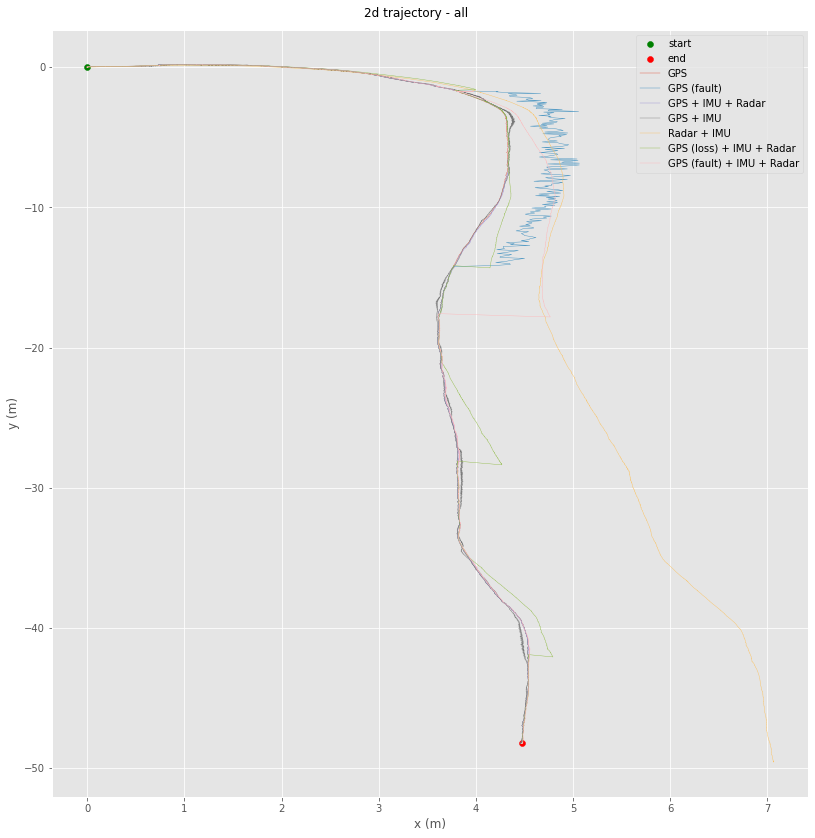

In [36]:
# visualize position
fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(gps_pos[0,0], gps_pos[0,1], color="green", label="start")
ax.scatter(gps_pos[-1,0], gps_pos[-1,1], color="red", label="end")
ax.plot(gps_pos[:,0], gps_pos[:,1], linewidth=.4, label="GPS")
ax.plot(gps_posf[:,0], gps_posf[:,1], linewidth=.4, label="GPS (fault)")
ax.plot(p0[:,0], p0[:,1], linewidth=.4, label="GPS + IMU + Radar")
ax.plot(p1[:,0], p1[:,1], linewidth=.4, label="GPS + IMU")
ax.plot(p2[:,0], p2[:,1], linewidth=.4, label="Radar + IMU")
ax.plot(pl[:,0], pl[:,1], linewidth=.4, label="GPS (loss) + IMU + Radar")
ax.plot(pf[:,0], pf[:,1], linewidth=.4, label="GPS (fault) + IMU + Radar")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
ax.legend()

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.suptitle("2d trajectory - all")
plt.show()

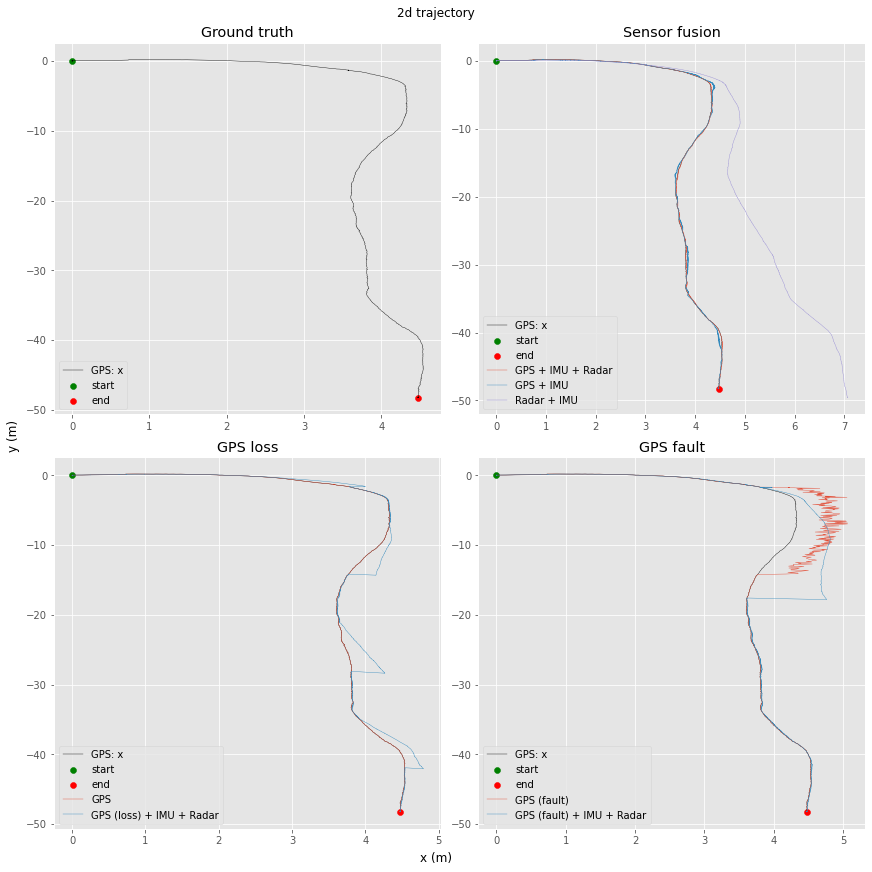

In [37]:
%matplotlib inline

# visualize position
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 12),
                        constrained_layout=True)

# add ground truth
for i in range(2):
    for j in range(2):
        axs[i,j].plot(gps_pos[:,0], gps_pos[:,1], 'k-', linewidth=.4, label="GPS: x")
        axs[i,j].scatter(gps_pos[0,0], gps_pos[0,1], color="green", label="start")
        axs[i,j].scatter(gps_pos[-1,0], gps_pos[-1,1], color="red", label="end")

# sensor fusion
axs[0,1].plot(p0[:,0], p0[:,1], linewidth=.4, label="GPS + IMU + Radar")
axs[0,1].plot(p1[:,0], p1[:,1], linewidth=.4, label="GPS + IMU")
axs[0,1].plot(p2[:,0], p2[:,1], linewidth=.4, label="Radar + IMU")

axs[1,0].plot(gps_pos[:,0], gps_pos[:,1], linewidth=.4, label="GPS")
axs[1,0].plot(pl[:,0], pl[:,1], linewidth=.4, label="GPS (loss) + IMU + Radar")

axs[1,1].plot(gps_posf[:,0], gps_posf[:,1], linewidth=.4, label="GPS (fault)")
axs[1,1].plot(pf[:,0], pf[:,1], linewidth=.4, label="GPS (fault) + IMU + Radar")
        
for i in range(2):
    for j in range(2):
        axs[i,j].legend()

axs[0,0].set_title("Ground truth")
axs[0,1].set_title("Sensor fusion")
axs[1,0].set_title("GPS loss")
axs[1,1].set_title("GPS fault")
        
fig.supxlabel("x (m)")
fig.supylabel("y (m)")
fig.suptitle("2d trajectory")
plt.show()

In [40]:
p2_short = np.empty((0,3), float)
for i in range(len(tt_gps_pos)):
    dt, idx = get_IMU_reading(tt_gps_pos[i], tt_state2)
    p2_short = np.append(p2_short, p2[idx].reshape(1,3), axis=0)

traj_RMSE(p2_short[:,0:2], gps_pos[:, 0:2])

1.1460691331139932

# END